In [1]:
## Import base libraries ##
import numpy as np
import math
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import pandas as pd
import GPy

In [46]:
## List of functions for GPR ##
## ============================ ##
from GPy.core.parameterization.priors import Prior
import weakref
class KDEPrior(Prior):
    _instances = []

    def __new__(cls, samples):  # Singleton:
#         if cls._instances:
#             cls._instances[:] = [instance for instance in cls._instances if instance()]
#             for instance in cls._instances:
#                 if instance().samples == samples:
#                     return instance()
        newfunc = super(Prior, cls).__new__
        if newfunc is object.__new__:
            o = newfunc(cls)
        else:
            o = newfunc(cls, samples)
        cls._instances.append(weakref.ref(o))
        return cls._instances[-1]()

    def __init__(self, samples):
        self.samples = samples
        self.kde = gaussian_kde(self.samples)

    def __str__(self):
        return "KDE"

    def lnpdf(self, x):
        return np.log(self.kde.pdf(x))

    def lnpdf_grad(self, x):
        # Approximate the gradient by calculating the difference in the log PDF at two close points
        epsilon = 1e-8
        log_pdf_grad = (np.log(self.kde.pdf(x + epsilon)) - np.log(self.kde.pdf(x - epsilon))) / (2 * epsilon)
        return log_pdf_grad

    def rvs(self, n=None):
        # Generate random samples from the KDE-based prior
        return self.kde.resample(size=n).flatten()


#Xtest that returns largest predictive std is
def find_Xtest(m, X, y, dim):
    #Create test data
    N = len(X) #in one dim
    n = 20 #in one dim
    step = np.abs(np.max(X) - np.min(X))/n # step size for Xtest
    
    r = []
    for i in range(dim):
        rx_i = np.arange(np.min(X), np.max(X), step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest_og = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest_og.shape = (n x dim)

    
    mu, std = m.predict_noiseless(Xnew = Xtest_og, full_cov = False)
    mu = mu[:,0]
    std = np.sqrt(np.abs(std))[:,0]
    Xtest_maxstd = Xtest_og[np.argmax(std)].reshape(-1,dim)
    return Xtest_maxstd    


def multistart(m, n_starts = 50, optimizer = "lbfgs", noise = 0.00001, fixed_noise = True):
    '''
    Optimizer methods: 'scg','lbfgs','org-bfgs','fmin_tnc','adam'
    '''
    #Number of optimization starts
    best_model = None
    best_log_likelihood = -np.inf
    
    ## Perform multistart optimization
    for i in range(n_starts):
        # Randomly initialize the kernel parameters
        m.randomize()
        
        # Optimize the model
        m.optimize(optimizer = optimizer)
        
        # Keep track of the best model based on log likelihood
        if m.log_likelihood() > best_log_likelihood:
            best_log_likelihood = m.log_likelihood()
            best_model = m.copy()  # Store the best model

        print("Multistart iteration = ",i,end="\r")
    m = best_model
    return m


#global error:
def global_error(m, minX, maxX, dim, f, n = 200, multiout = False, outputdim = 0, scaled = True):
    #Create test data
    step = np.abs(maxX - minX)/n # step size for Xtest
    
    r = []
    for i in range(dim):
        rx_i = np.arange(minX, maxX, step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest.shape = (n x dim)

    ytest = f(Xtest).reshape(-1,1) #observations (following true unknown function we wish to approx)
    
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    if multiout == True:
        if outputdim == 0:
            task_index = np.zeros((Xtest.shape[0], 1))
        if outputdim == 1:
            task_index = np.ones((Xtest.shape[0], 1))
        Xtest_with_index = np.hstack([Xtest, task_index])
        mu, std = m.predict_noiseless(Xnew =  Xtest_with_index, full_cov = False)
    else:
        mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)

    if scaled == True:
        #Normalized RMSE
        rmse = np.sqrt(np.mean((mu-ytest)**2))/np.std(ytest)
    else:
        rmse = np.sqrt(np.mean((mu-ytest)**2))
    return rmse
    

#local error (max error)
def local_error(m, minX, maxX, dim, f, n = 200, multiout = False, outputdim = 0, scaled = True):
    #Create test data
    step = np.abs(maxX - minX)/n # step size for Xtest
    
    r = []
    for i in range(dim):
        rx_i = np.arange(minX, maxX, step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest.shape = (n x dim)

    ytest = f(Xtest).reshape(-1,1) #observations (following true unknown function we wish to approx)
    
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    if multiout == True:
        if outputdim == 0:
            task_index = np.zeros((Xtest.shape[0], 1))
        if outputdim == 1:
            task_index = np.ones((Xtest.shape[0], 1))
        Xtest_with_index = np.hstack([Xtest, task_index])
        mu, std = m.predict_noiseless(Xnew =  Xtest_with_index, full_cov = False)
    else:
        mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)


    if scaled == True:
        #Normalized RMSE
        maxerror = np.max(np.abs(mu-ytest))/np.std(ytest)
    else:
        maxerror = np.max(np.abs(mu-ytest))
    return maxerror


def grid_l_var(m, X, y, metric = "loglike", n = 200):
    '''
    metric = "loglike", "rmse", "maxerror", "maxstd"
    '''
    n = 200
    l_list = np.linspace(0.1, 10, n)
    sigma_list = np.linspace(0.1,20,n)
    z_list = []
    i = 0
    if metric == "loglike":
        for li in l_list:
            m.kern.lengthscale = li
            z_sigma = []
            for sigmai in sigma_list:
                m.kern.variance = sigmai
                z_sigma.append(m.log_likelihood())
            z_list.append(np.array(z_sigma))
            i = i+1
            print(i/n,end="\r")
        z_list = np.array(z_list)
    elif metric == "rmse":
        for li in l_list:
            m.kern.lengthscale = li
            z_sigma = []
            for sigmai in sigma_list:
                m.kern.variance = sigmai
                z_sigma.append(global_error(m, X, y))
            z_list.append(np.array(z_sigma))
            i = i+1
            print(i/n,end="\r")
        z_list = np.array(z_list)
    elif metric == "maxerror":
        for li in l_list:
            m.kern.lengthscale = li
            z_sigma = []
            for sigmai in sigma_list:
                m.kern.variance = sigmai
                z_sigma.append(local_error(m, X, y))
            z_list.append(np.array(z_sigma))
            i = i+1
            print(i/n,end="\r")
        z_list = np.array(z_list)
    elif metric == "maxstd":
        for li in l_list:
            m.kern.lengthscale = li
            z_sigma = []
            for sigmai in sigma_list:
                m.kern.variance = sigmai
                z_sigma.append(max_std(m, X))
            z_list.append(np.array(z_sigma))
            i = i+1
            print(i/n,end="\r")
        z_list = np.array(z_list)
    else:
        raise Exception("Not valid metric") 
        

    l_min_id = np.unravel_index(np.nanargmax(z_list), z_list.shape)[0]
    sigma_min_id = np.unravel_index(np.nanargmax(z_list), z_list.shape)[1]
    l_min, sigma_min = l_list[l_min_id], sigma_list[sigma_min_id]
    print("lmax, sigmamax = ", l_min, sigma_min)
    return l_list, sigma_list, z_list


## List of functions for 1D GPR ##
## ============================ ##
#generate points that aren't too close to each other
def generate_points(minX, maxX, N, min_distance = 0.05, dim = 1):
    if min_distance == 0.05:
        min_distance = np.abs(maxX-minX)/(2*N)
        print(min_distance)
    points = []
    while len(points) < N:
        # Generate a random point
        point = np.random.uniform(-5, 5, size=(2,dim)) # Adjust range as needed
        if len(points) == 0:
            points.append(point)
        else:
            # Check distance with existing points
            valid_point = True
            for existing_point in points:
                distance = np.linalg.norm(point - existing_point)
                if distance < min_distance:
                    valid_point = False
                    break
            if valid_point:
                points.append(point)
    #print(np.concatenate(points))
    return np.concatenate(points)


#Lengthscale initial guess
def wavelength(X,y):
    '''
    python write a function that iteratively increases the neighborhood size on the x axis
    around the global maximum of y until it finds the smallest y value in a neighborhood
    where the y values are decreasing just before they begin increasing. return the distance
    along the x axis between the global maximum of y and that smallest y value
    '''
    ymax = np.max(y)
    ymax_i = np.argmax(y)
    ymax_x = X[ymax_i]

    loweri = 0
    upperi= len(y)-1

    ysmall_right = ymax
    ysmall_right_i = ymax_i
    i = ymax_i + 1
    while i <= upperi:    
        if y[i-1] >= y[i]: #if left y > right y
            ysmall_right = y[i]
            ysmall_right_i = i
            i = i+1
        else:
            break

    ysmall_left = ymax
    ysmall_left_i = ymax_i
    i = ymax_i - 1    
    while i >= loweri:
        if y[i] <= y[i+1]: #if left y < right y
            ysmall_left = y[i]
            ysmall_left_i = i
            i = i-1
        else:
            break
            
    if ysmall_right<ysmall_left:
        ysmall = ysmall_right
        ysmall_i = ysmall_right_i
    else:
        ysmall = ysmall_left
        ysmall_i = ysmall_left_i
    #print(ysmall)
    ysmall_x = X[ysmall_i]
    #print(ysmall_x)
    wavelength = np.abs(ymax_x - ysmall_x)
    #print(wavelength)
    return wavelength[0]


def rbf_init_par(X,y):
    init_sigma_n = 0#0.0001 #np.std(y) # guess for observation noise
    init_len_scale = wavelength(X,y)
    init_sigma_f = np.abs(np.max(y) - np.min(y)) #this is the range of the observations
    init_par = [init_sigma_n, init_len_scale, init_sigma_f]
    return init_par
    

#plot the posterior distribution of GPR (GPy version)
def GPy_plot_post(m, X, minX, maxX, y, f, n = 200):
    '''
    Plot the posterior distribution of GPR
    '''
    Xtest = np.linspace(minX, maxX, n).reshape(-1,1)
    
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)
    mu = mu[:,0]
    std = np.sqrt(np.abs(std))[:,0]
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(8,4))

    # Plot training data
    plt.plot(X, y, 'kx', ms=9)
    # Plot test points
    plt.plot(Xtest, f(Xtest), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, '-', lw=2, color = "#3465a4")
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest[:,0], mu-2*std, mu+2*std, color="#e2ebf5")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()
    
    
## List of functions for 2D GPR ##
## ============================ ##
def GPy_plot_2D(m, X, y):
    dim = 2
    
    #Create test data
    N = len(X) #in one dim
    n = 20 #in one dim
    step = np.abs(np.max(X) - np.min(X))/n # step size for Xtest
    
    r = []
    for i in range(dim):
        rx_i = np.arange(np.min(X), np.max(X), step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest.shape = (n x dim)
    
    
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)
    
    ##Render plots
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    # Plot predictive mean
    gx1, gx2 = g[0], g[1]
    
    #Render plots
    surf = ax.plot_surface(gx1, gx2, mu.reshape(gx1.shape), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False, alpha = 0.3)
    
    #Plot training data
    ax.scatter(X[:,0], X[:,1], y, c = y, marker = 'o', cmap=cm.coolwarm)
    
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

## Latin Hypercube Sampling (LHS)
A Latin square is an nxn matrix with $n$ different elements such that each element only occurs once in each row and column. A Latin hypercube is a generalization of this idea to any number of dimensions. If we have $N$ features, the range of each feature is divided into $M$ equally sized intervals. We then place the M samples points in a Latin hypercube configuration.

Pearson correlation coefficient
[[1.         0.98020097]
 [0.98020097 1.        ]]


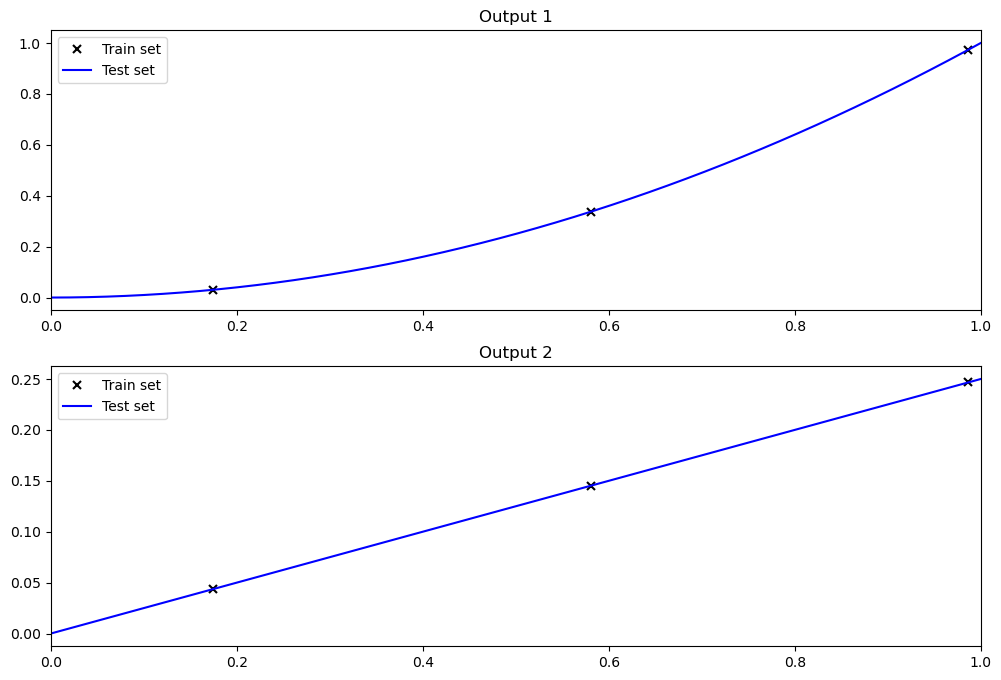

In [5]:
from pyDOE import lhs

#These functions generate data corresponding to two outputs
f1 = lambda x: x**2
f2 = lambda x: 0.25*f1(x)**(0.5)

#{X,Y} training set for each output
num_samples = 3
xmin = 0
xmax = 1
X1 = (xmax-xmin)*np.sort(lhs(1, samples=num_samples, criterion='maximin'))+xmin;
X2 = (xmax-xmin)*np.sort(lhs(1, samples=num_samples, criterion='maximin'))+xmin;
Y1 = f1(X1).reshape(-1,1) # + np.random.gumbel(0, 0.25, num_samples).reshape(-1,1)
Y2 = f2(X2).reshape(-1,1) # + np.random.gumbel(0, 0.25, num_samples).reshape(-1,1)

print("Pearson correlation coefficient")
print(np.corrcoef(Y1.T,Y2.T))

#{X,Y} test set for each output
Xt1 = np.linspace(xmin, xmax, 200).reshape(-1,1)
Xt2 = np.linspace(xmin, xmax, 200).reshape(-1,1)
Yt1 = f1(Xt1)
Yt2 = f2(Xt2)

#Plot the data
xlim = (xmin,xmax); ylim = (0,50)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1.set_xlim(xlim)
ax1.set_title('Output 1')
ax1.plot(X1[:,:1],Y1,'kx',mew=1.5,label='Train set')
ax1.plot(Xt1[:,:1],Yt1,'b-',mew=1.5,label='Test set')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.set_xlim(xlim)
ax2.set_title('Output 2')
ax2.plot(X2[:,:1],Y2,'kx',mew=1.5,label='Train set')
ax2.plot(Xt2[:,:1],Yt2,'b-',mew=1.5,label='Test set')
ax2.legend()

## 1-D Multiple response GP

### Intro
Say we want to infer multiple outputs which have the same source of uncertainty from the inputs, like in the example above. We may certainly perform two individual GPs, one for output 1 and the other for output 2, we could have a more informative model if we considered the covariance between the two outputs.
<br><br>
So, if we were to only consider the two models individually, we have

$$f_1(x)\sim GP(0,K_1(x,x'))$$

$$f_2(x)\sim GP(0,K_2(x,x'))$$

$$y(x_{i,1}) = f_1(x_{i,1})+\epsilon_i$$

$$y(x_{i,1}) = f_2(x_{i,2})+\epsilon_i$$

$$\epsilon_i\sim N(0,\sigma^2)$$

Our observed data is $D_1 = \{(x_{i,1},y(x_{i,1}))\vert i=1,\ldots,N\}$ and $D_2 = \{(x_{i,2},y(x_{i,2}))\vert i=1,\ldots,N\}$. Then for each GP we have

$$
[y(x_{1,1})\ldots y(x_{N,1})]^T\sim N(0,K_1+\sigma_1^2I)
$$

$$
[y(x_{1,2})\ldots y(x_{N,2})]^T\sim N(0,K_2+\sigma_2^2I)
$$

where

$$
K_1=[[k(x_{1,1},x_{1,1})\ldots k(x_{N,1},x_{1,1})]^T \ldots [k(x_{1,1},x_{N,1})\ldots k(x_{N,1},x_{N,1})]^T]
$$

$$
K_2=[[k(x_{1,2},x_{1,2})\ldots k(x_{N,2},x_{1,2})]^T \ldots [k(x_{1,2},x_{N,2})\ldots k(x_{N,2},x_{N,2})]^T]
$$

<br><br>

We can combine these individual GPs as one model:

$$
[y_1,y_2]^T \sim N([0,0]^T, [[K_1,0]^T [0,K_2]^T] + [[\sigma_1^2I,0]^T [0,\sigma_2^2I]^T])
$$

$$
y\sim N(0,K_{f,f}+\Sigma)
$$

Rather than having $K_{f,f} = [[K_1,0]^T [0,K_2]^T]$, we want to find diagonal terms to take into consideration interaction between one output model and the other. There are two approaches we can take: 1) intrisic coregionalization model (ICM) or 2) linear model of coregionalization (LMC). 

---

### ICM
ICM considers $d=1,\ldots,R$ (example: $R=2$) multi-output models with only one latent covariance $K$.

$$f_d(x)\sim GP(0,K(x,x'))$$

Individually, we have the following $R$ outputs $f_d(x)$ defined above which input the same feature space $x$. Taking a sample from a GP of that kernel, $u^j(x)\sim GP(0,K(x,x'))$, we assume the linear transformations

$$
f_d(x)=\sum_{j=1}^P a_d^ju^j(x)
$$

where $d = 1,\ldots,R$, $j=1,\ldots P\leq R$, and

$$
a^j = [a_1^j,\ldots, a_R^j]^T
$$

is a $R$x$1$ vector. We further define the $R$x$1$ vector

$$
f(x) = [f_1(x),\ldots,f_R(x)]^T
$$

$$
A = [a^1 \ldots a^P]
$$

, a $R$x$P$ matrix,

$$
B = AA^T
$$

where the rank of this $R$x$R$ matrix $B$ is $P$. Then,

$$
K_{ICM} = cov(f(x),f(x')) = AA^T K(x,x') = B K(x,x')
$$

Note that we write $B = WW^T+diag(\kappa)$ to ensure $B$ is positive definite.

---

### LMC
The ICM is a special case of the LMC with one input kernel $K$. If we have two or more input kernels $K_1,K_2,\ldots$, the LMC model is the sum of individual ICM models.

$$
K_{LMC} = B_1K_{ICM_1} + B_2K_{ICM_2} + \cdots
$$


#### Individaul GPs

In [36]:
input_dim = 1 #1D problem
P = 1 #number of latent gp samples
n_starts = 50 #number of multistart iterations
rmse_num = 4 #number of test points for rmse calc

Multistart iteration =  49
Name : GP regression
Objective : 2.110952911695538
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  0.4867390846056519  |      +ve      |        
  rbf.lengthscale          |   0.548509266704494  |      +ve      |        
  Gaussian_noise.variance  |                 0.0  |   +ve fixed   |        

Log-likelihood =  -2.110952911695538
RMSE =  0.03631297985061097
Max error =  0.2197515443504438


<Figure size 640x480 with 0 Axes>

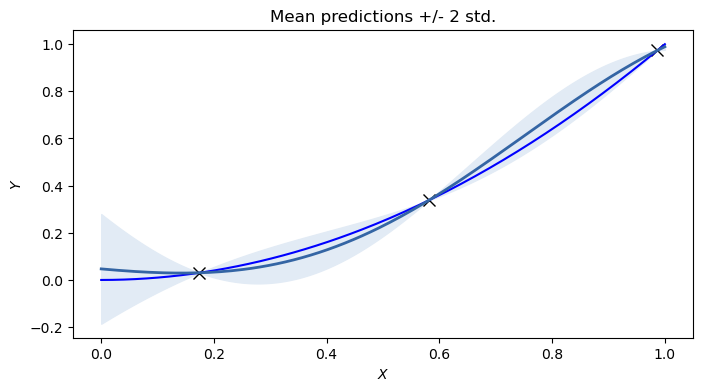

In [37]:
#Define kernel
K=GPy.kern.RBF(input_dim = input_dim, variance = 1, lengthscale = 1, ARD = False)

#Define GPR
model1 = GPy.models.GPRegression(X1,Y1,K)

#Optimize
model1.Gaussian_noise.variance = 0
model1.Gaussian_noise.variance.fix()
model1 = multistart(model1, n_starts = n_starts, optimizer = "lbfgs")

print(model1)
print("")
print("Log-likelihood = ", model1.log_likelihood())
print("RMSE = ", global_error(model1, xmin, xmax, input_dim, f1, n = rmse_num, multiout = False, outputdim = 0, scaled=False))
print("Max error = ", local_error(model1, xmin, xmax, input_dim, f1, n = rmse_num, multiout = False, outputdim = 0))

GPy_plot_post(model1, X1, xmin, xmax, Y1, f1)

Multistart iteration =  49
Name : GP regression
Objective : -3.8970937917536985
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  3.7563255482700235  |      +ve      |        
  rbf.lengthscale          |  13.381925773644904  |      +ve      |        
  Gaussian_noise.variance  |                 0.0  |   +ve fixed   |        

Log-likelihood =  3.8970937917536985
RMSE =  3.630873506316989e-05
Max error =  0.000988560196663239


<Figure size 640x480 with 0 Axes>

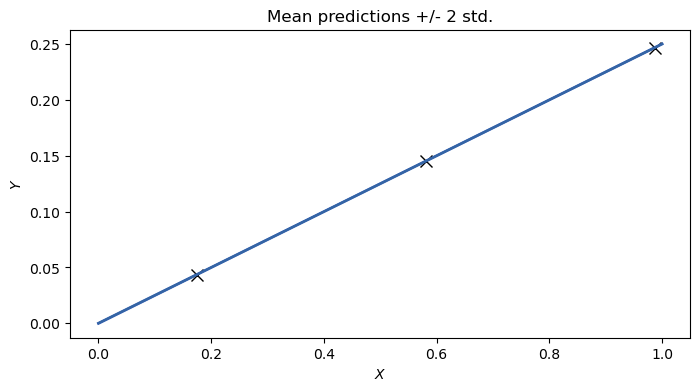

In [38]:
#Define GPR
K=GPy.kern.RBF(input_dim = input_dim, variance = 1, lengthscale = 1, ARD = False)
model2 = GPy.models.GPRegression(X2,Y2,K)

#Optimize
model2.Gaussian_noise.variance = 0
model2.Gaussian_noise.variance.fix()
model2 = multistart(model2, n_starts = n_starts, optimizer = "lbfgs")

print(model2)
print("")
print("Log-likelihood = ", model2.log_likelihood())
print("RMSE = ", global_error(model2, xmin, xmax, input_dim, f2, n = rmse_num, multiout = False, outputdim = 0,scaled=False))
print("Max error = ", local_error(model2, xmin, xmax, input_dim, f2, n = rmse_num, multiout = False, outputdim = 0))

GPy_plot_post(model2, X2, xmin, xmax, Y2, f2)

In [39]:
#Define B matrix
B = GPy.kern.Coregionalize(input_dim=input_dim, output_dim=2) #two 
multkernel = K.prod(B,name='B.K')
print(multkernel)

  B_K.             |               value  |  constraints  |  priors
  rbf.variance     |  3.7558026960017905  |      +ve      |        
  rbf.lengthscale  |  13.381109512886924  |      +ve      |        
  coregion.W       |              (2, 1)  |               |        
  coregion.kappa   |                (2,)  |      +ve      |        


In [40]:
#Components of B
print('W matrix\n',B.W)
print('\nkappa vector\n',B.kappa)
print('\nB matrix\n',B.B)

W matrix
   index  |  coregion.W  |  constraints  |  priors
  [0 0]  |  0.08044472  |               |        
  [1 0]  |  0.18386706  |               |        

kappa vector
   index  |  coregion.kappa  |  constraints  |  priors
  [0]    |      0.50000000  |      +ve      |        
  [1]    |      0.50000000  |      +ve      |        

B matrix
 [[0.50647135 0.01479113]
 [0.01479113 0.5338071 ]]


In [41]:
print(B.W*B.W.T + 0.5*np.eye(2,2))

[[0.50647135 0.01479113]
 [0.01479113 0.5338071 ]]


In [43]:
K=GPy.kern.RBF(input_dim = input_dim, variance = 1, lengthscale = 1, ARD = False)
icm = GPy.util.multioutput.ICM(input_dim=input_dim, num_outputs=2, kernel=K, W_rank=P)
print(icm)

  ICM.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  B.W              |  (2, 1)  |               |        
  B.kappa          |    (2,)  |      +ve      |        


#### Combined Model

Multistart iteration =  49
Name : gp
Objective : -3.602649359252487
Number of Parameters : 8
Number of Optimization Parameters : 6
Updates : True
Parameters:
  gp.                                    |                value  |  constraints  |  priors
  ICM.rbf.variance                       |  0.01832648358628989  |      +ve      |        
  ICM.rbf.lengthscale                    |  0.43432077985509077  |      +ve      |        
  ICM.B.W                                |               (2, 1)  |               |        
  ICM.B.kappa                            |                 (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |                  0.0  |   +ve fixed   |        
  mixed_noise.Gaussian_noise_1.variance  |                  0.0  |   +ve fixed   |        

Log-likelihood =  3.602649359252487

 OUTPUT 1
RMSE =  0.04698217008179104
Max error =  0.07187300208309955

 OUTPUT 2
RMSE =  0.01571841258081137
Max error =  0.02637869398889987


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d0f4587040>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1d0f461ef50>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1d0f4e3e230>]}

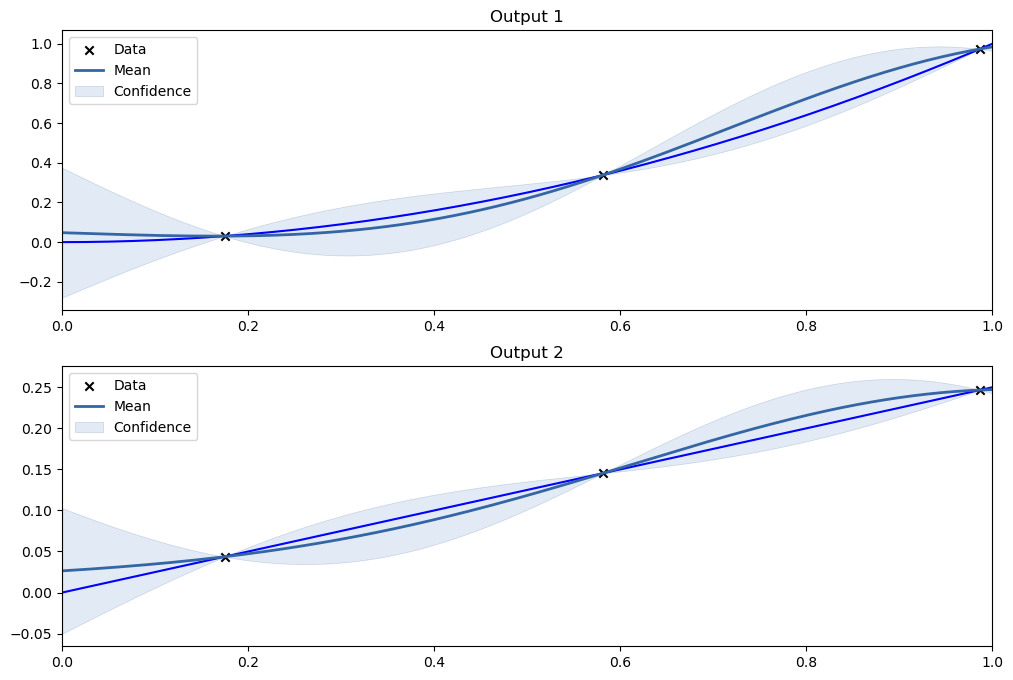

In [47]:
#Define GPR
m = GPy.models.GPCoregionalizedRegression([X1,X2],[Y1,Y2],kernel=icm)

#Constrain parameters
m['.*noise'] = 0
m['.*noise'].fix()
# m['.*lengthscale'] = 13
# m['.*lengthscale'].fix()

#Optimize
m = multistart(m, n_starts = n_starts, optimizer = "lbfgs")

#Results
print(m)
print("")
print("Log-likelihood = ", m.log_likelihood())
print("\n OUTPUT 1")
print("RMSE = ", global_error(m, xmin, xmax, input_dim, f1, n = rmse_num, multiout = True, outputdim = 0,scaled=False))
print("Max error = ", local_error(m, xmin, xmax, input_dim, f1, n = rmse_num, multiout = True, outputdim = 0,scaled=False))
print("\n OUTPUT 2")
print("RMSE = ", global_error(m, xmin, xmax, input_dim, f2, n = rmse_num, multiout = True, outputdim = 1,scaled=False))
print("Max error = ", local_error(m, xmin, xmax, input_dim, f2, n = rmse_num, multiout = True, outputdim = 1,scaled=False))


#Plot
fig = plt.figure(figsize=(12,8))
xlim = (xmin, xmax)
#Output 1
ax1 = fig.add_subplot(211)
ax1.set_xlim(xlim)
ax1.set_title('Output 1')
ax1.plot(Xt1[:,:1],Yt1,'b-',mew=1.5)
m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,num_samples),ax=ax1)

#Output 2
ax2 = fig.add_subplot(212)
ax2.set_xlim(xlim)
ax2.set_title('Output 2')
ax2.plot(Xt2[:,:1],Yt2,'b-',mew=1.5)
m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(num_samples,2*num_samples),ax=ax2)

In [30]:
#Components of B
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)
print('\nB matrix\n',icm.B.B)

W matrix
   index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  4.83476594  |               |        
  [1 0]  |  1.17347125  |               |        

kappa vector
   index  |  gp.ICM.B.kappa  |  constraints  |  priors
  [0]    |      2.13414431  |      +ve      |        
  [1]    |      0.01539801  |      +ve      |        

B matrix
 [[25.50910597  5.67345881]
 [ 5.67345881  1.39243278]]
